## K-Means Clustering for structure identification

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

Documentation K-Means:
* https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
* https://scikit-learn.org/stable/modules/clustering.html#k-means

Multi-linear regression:
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [9]:
train_data = pd.read_csv("dataset/matlab_1_train.csv")

In [10]:
n_fuzzy_sets = 3
outer_bound_factor = 1
inner_bound_factor = 0.3

In [11]:
X = train_data.iloc[:, 1:].to_numpy()
X

array([[ 5.450000e-02,  7.969000e+02,  6.687490e+02, ...,  1.867500e+01,
         2.539096e+01,  3.575400e+00],
       [ 8.182000e-01,  1.598000e+02,  6.671610e+02, ...,  1.976250e+01,
         3.445457e+01,  5.274200e+00],
       [-1.525000e-01,  5.601000e+02,  4.445890e+02, ...,  3.010000e+01,
         4.191501e+01,  1.808905e+01],
       ...,
       [ 4.170000e-02,  6.322000e+02,  6.426440e+02, ...,  2.240000e+01,
         3.363775e+01,  8.526920e+00],
       [-5.328000e-01,  2.882000e+02,  5.303860e+02, ...,  1.812857e+01,
         3.001427e+01,  8.121220e+00],
       [-2.560000e-01,  6.322000e+02,  6.426440e+02, ...,  2.240000e+01,
         3.363775e+01,  8.526920e+00]])

In [12]:
cluster_obj = KMeans(n_clusters=10, n_init=10)
cluster_fit = cluster_obj.fit(X)
merged_data = pd.merge(train_data.iloc[:, 1:], pd.DataFrame({"Subcluster_number" : cluster_fit.labels_}), left_index=True, right_index=True)

In [13]:
merged_data

,Relative_yield_change,P,E,PB,Tave,Tmax,Tmin,Subcluster_number
0,0.0545,796.9,668.749,128.151,18.67500,25.39096,3.57540,7
1,0.8182,159.8,667.161,-507.361,19.76250,34.45457,5.27420,5
2,-0.1525,560.1,444.589,115.511,30.10000,41.91501,18.08905,0
3,-0.1485,502.5,510.423,-7.923,18.16667,25.69895,6.81734,8
4,-0.4000,681.0,605.264,75.736,23.83333,34.08730,12.49785,7
...,...,...,...,...,...,...,...,...
1024,0.0233,558.3,512.182,46.118,24.42500,26.67880,17.19974,0
1025,-0.0259,404.1,543.628,-139.528,20.65000,30.93442,7.87919,1
1026,0.0417,632.2,642.644,-10.444,22.40000,33.63775,8.52692,4
1027,-0.5328,288.2,530.386,-242.186,18.12857,30.01427,8.12122,1


In [14]:
merged_data.iloc[:, 1:-1].columns

Index(['P', 'E', 'PB', 'Tave', 'Tmax', 'Tmin'], dtype='object')

In [15]:
feature_sets = []
subclusters = []
mfs = []
clusters = {i : [] for i in np.unique(cluster_fit.labels_)}

for k in range(1, len(merged_data.iloc[:, 1:-1].columns)+1):
    raw_mfs = cluster_fit.cluster_centers_[:,k].reshape(-1, 1)
    # Reduce amount of mfs by clustering in one dimension
    reduced_mfs_middle = KMeans(n_clusters=n_fuzzy_sets, n_init=5).fit(raw_mfs)
    feature_sets.append(reduced_mfs_middle.cluster_centers_.ravel())
    subcluster_in_clusters = [[] for i in np.unique(reduced_mfs_middle.labels_)]
    for subcluster_number in range(len(raw_mfs)):
        cur_cluster_number = reduced_mfs_middle.labels_[subcluster_number]
        clusters[subcluster_number].append(cur_cluster_number)
        subcluster_in_clusters[cur_cluster_number].append(subcluster_number)
    
    cur_mfs = []
    for cluster, subclusters in enumerate(subcluster_in_clusters):
        # For each cluster in subcluster calculate std for current feature
        cur_std = merged_data[merged_data["Subcluster_number"].isin(np.unique(subclusters))].iloc[:, k].std()
        cur_min = merged_data[merged_data["Subcluster_number"].isin(np.unique(subclusters))].iloc[:, k].min()
        cur_max = merged_data[merged_data["Subcluster_number"].isin(np.unique(subclusters))].iloc[:, k].max()
        cur_center = feature_sets[k-1][cluster]
        cur_mfs.append([cur_center - (abs(cur_center - cur_min)), cur_center - cur_std*inner_bound_factor, cur_center + cur_std*inner_bound_factor, cur_center + (abs(cur_center - cur_max))])

    mfs.append(cur_mfs)

In [16]:
mfs

[[[1151.7, 1368.1965678680563, 1460.4177178462296, 1574.3],
  [-42.0, 365.72960020898586, 453.36255250317686, 861.9000053],
  [623.5, 813.8769478941857, 897.9085538802802, 1311.8]],
 [[381.057, 528.8340925281175, 572.4543597230181, 810.192],
  [608.938, 684.2651446840232, 735.2322084771026, 1020.887],
  [249.642, 440.033254000338, 477.21668237169007, 607.571]],
 [[-741.692, -217.13526962031102, -139.6030680802499, 22.22800000000001],
  [4.324999999999989, 189.36289759203223, 264.5730561765189, 606.422],
  [746.402, 849.5004549558399, 899.7851164727314, 957.391]],
 [[6.914290000000001, 18.52380414701308, 21.46741801920909, 31.78],
  [15.41667, 21.968474544850043, 25.049742252292813, 30.05],
  [8.02857, 16.0779932707763, 19.377960425093466, 31.72]],
 [[20.50167, 29.170029293222527, 31.69525554520699, 41.91501],
  [18.50414, 27.0317041062195, 30.33046348590816, 41.81672],
  [22.15133, 25.410972593836913, 26.97856224324642, 34.7436]],
 [[-9.697759999999999, 3.7345884905428095, 7.1997242118

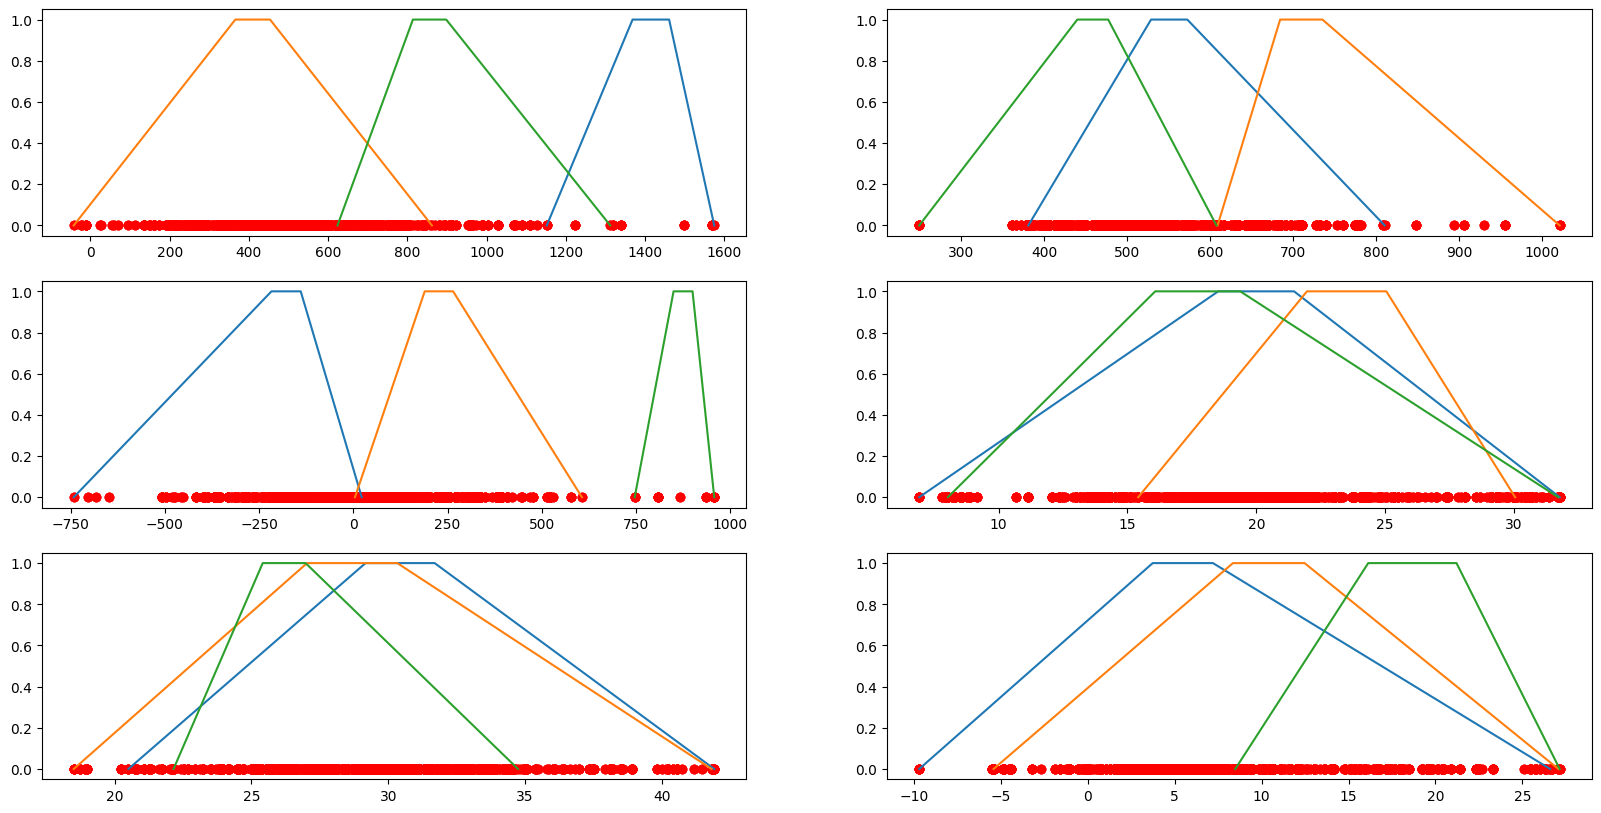

In [17]:
fig, ax = plt.subplots(3,2, figsize=(20, 10))
for plot in range(0,6):
    for mf in mfs[plot]:
        ax[int(plot / 2)][plot % 2].plot(mf, [0,1,1,0])
        ax[int(plot / 2)][plot % 2].scatter(merged_data.iloc[:, plot+1], np.zeros(merged_data.shape[0]), c="r")

plt.show()

In [18]:
feature_sets

[array([1414.30714286,  409.54607636,  855.89275089]),
 array([550.64422613, 709.74867658, 458.62496819]),
 array([-178.36916885,  226.96797688,  874.64278571]),
 array([19.99561108, 23.5091084 , 17.72797685]),
 array([30.43264242, 28.6810838 , 26.19476742]),
 array([ 5.46715635, 10.41016497, 18.67120786])]

In [19]:
clusters

{0: [1, 2, 1, 0, 0, 1],
 1: [1, 0, 0, 0, 0, 0],
 2: [2, 2, 1, 1, 0, 1],
 3: [0, 0, 2, 1, 0, 2],
 4: [1, 1, 0, 0, 1, 1],
 5: [1, 0, 0, 2, 0, 0],
 6: [1, 2, 0, 2, 1, 0],
 7: [2, 0, 1, 0, 0, 1],
 8: [1, 0, 0, 0, 0, 0],
 9: [2, 1, 1, 0, 2, 1]}

In [20]:
test_mfs = cluster_fit.cluster_centers_[:,0].reshape(-1, 1)
np.concatenate((test_mfs, np.unique(cluster_fit.labels_).reshape(-1, 1)), axis=1)

array([[-5.25748503e-02,  0.00000000e+00],
       [ 7.15285714e-02,  1.00000000e+00],
       [-8.49825397e-02,  2.00000000e+00],
       [-4.20285714e-02,  3.00000000e+00],
       [ 1.65009574e-01,  4.00000000e+00],
       [ 1.02485714e-01,  5.00000000e+00],
       [ 1.99127660e-02,  6.00000000e+00],
       [ 1.13656442e-02,  7.00000000e+00],
       [-4.56881657e-02,  8.00000000e+00],
       [ 7.24375000e-03,  9.00000000e+00]])

Here the consequents are calculated by LinearRegression

In [21]:
subclusters = merged_data["Subcluster_number"].unique()
r2_scores = []
consequent_params = []
intercepts = []
for subcluster in subclusters:
    cur_X = merged_data[merged_data["Subcluster_number"] == subcluster].iloc[:, 1:-1]
    cur_Y = merged_data[merged_data["Subcluster_number"] == subcluster].iloc[:, 0]
    cur_linear = LinearRegression().fit(cur_X, cur_Y)
    consequent_params.append(cur_linear.coef_)
    intercepts.append(cur_linear.intercept_)
    r2_scores.append(cur_linear.score(cur_X, cur_Y))


In [28]:
merged_data

,Relative_yield_change,P,E,PB,Tave,Tmax,Tmin,Subcluster_number
0,0.0545,796.9,668.749,128.151,18.67500,25.39096,3.57540,7
1,0.8182,159.8,667.161,-507.361,19.76250,34.45457,5.27420,5
2,-0.1525,560.1,444.589,115.511,30.10000,41.91501,18.08905,0
3,-0.1485,502.5,510.423,-7.923,18.16667,25.69895,6.81734,8
4,-0.4000,681.0,605.264,75.736,23.83333,34.08730,12.49785,7
...,...,...,...,...,...,...,...,...
1024,0.0233,558.3,512.182,46.118,24.42500,26.67880,17.19974,0
1025,-0.0259,404.1,543.628,-139.528,20.65000,30.93442,7.87919,1
1026,0.0417,632.2,642.644,-10.444,22.40000,33.63775,8.52692,4
1027,-0.5328,288.2,530.386,-242.186,18.12857,30.01427,8.12122,1


In [22]:
r2_scores

[0.04547643572219695,
 0.1303265698868621,
 0.1962982806357264,
 0.10700748654450198,
 0.18359326211069782,
 0.43359139421459747,
 0.2031533124626279,
 0.35231303004342696,
 0.21003846635036683,
 0.670140101938147]

In [23]:
consequent_params

[array([ 1.26376509e+02, -1.26375684e+02, -1.26376262e+02,  1.29696907e-02,
         1.78609943e-03,  2.10418328e-03]),
 array([ 1.79913772e+11, -1.79913772e+11, -1.79913772e+11,  3.63311768e-02,
         1.03368759e-02, -8.94546509e-03]),
 array([ 1.16527669e+01, -1.16536199e+01, -1.16527155e+01, -1.42875429e-02,
         2.26418659e-02,  4.02539212e-03]),
 array([ 1.70098778e+02, -1.70098330e+02, -1.70099944e+02, -6.06528820e-02,
         3.81736907e-02,  2.83735111e-02]),
 array([-3.49161714e+02,  3.49163014e+02,  3.49161766e+02, -1.05101071e-02,
         4.66128853e-02, -2.09059428e-02]),
 array([ 2.78876317e+02, -2.78876823e+02, -2.78876572e+02,  4.92073047e-02,
        -1.02522043e-01,  1.58785030e-02]),
 array([-1.39856542e+03,  1.39856072e+03,  1.39855912e+03,  1.58469418e-01,
        -9.95363756e-02, -5.31583821e-02]),
 array([ 3.54723346e+02, -3.54722663e+02, -3.54722796e+02,  1.87789809e-02,
        -1.45577849e-02,  1.04073490e-02]),
 array([-3.91214729e+01,  3.91213063e+01

Prepare the mf representation

In [24]:
rows = []
feature_names = merged_data.iloc[:, 1:-1].columns
for i, feature in enumerate(mfs):
    for j, mf in enumerate(feature):
        rows.append([i, feature_names[i], j, mf[0], mf[1], mf[2], mf[3]])

fuzzy_set_table = pd.DataFrame(rows, columns=["feature_id", "feature_name", "set_id", "a", "b", "c", "d"])


In [25]:
rows = []
for rule_number, rule in clusters.items():
    rows.append(np.concatenate((rule, consequent_params[rule_number], [intercepts[rule_number]], [r2_scores[rule_number]])))

rule_base = pd.DataFrame(rows, columns=np.concatenate((feature_names, ["p"+str(i) for i in range(len(feature_names))], ["r"], ["r2"])))

In [26]:
rule_base

,P,E,PB,Tave,Tmax,Tmin,p0,p1,p2,p3,p4,p5,r,r2
0,1.0,2.0,1.0,0.0,0.0,1.0,1.263765e+02,-1.263757e+02,-1.263763e+02,1.296969e-02,1.786099e-03,2.104183e-03,-8.028017e-01,0.045476
1,1.0,0.0,0.0,0.0,0.0,0.0,1.799138e+11,-1.799138e+11,-1.799138e+11,3.633118e-02,1.033688e-02,-8.945465e-03,-2.315024e+00,0.130327
2,2.0,2.0,1.0,1.0,0.0,1.0,1.165277e+01,-1.165362e+01,-1.165272e+01,-1.428754e-02,2.264187e-02,4.025392e-03,-7.700138e-02,0.196298
3,0.0,0.0,2.0,1.0,0.0,2.0,1.700988e+02,-1.700983e+02,-1.700999e+02,-6.065288e-02,3.817369e-02,2.837351e-02,-4.840361e-01,0.107007
4,1.0,1.0,0.0,0.0,1.0,1.0,-3.491617e+02,3.491630e+02,3.491618e+02,-1.051011e-02,4.661289e-02,-2.090594e-02,-1.729391e+00,0.183593
5,1.0,0.0,0.0,2.0,0.0,0.0,2.788763e+02,-2.788768e+02,-2.788766e+02,4.920730e-02,-1.025220e-01,1.587850e-02,2.030053e+00,0.433591
6,1.0,2.0,0.0,2.0,1.0,0.0,-1.398565e+03,1.398561e+03,1.398559e+03,1.584694e-01,-9.953638e-02,-5.315838e-02,3.108991e+00,0.203153
7,2.0,0.0,1.0,0.0,0.0,1.0,3.547233e+02,-3.547227e+02,-3.547228e+02,1.877898e-02,-1.455778e-02,1.040735e-02,-6.991298e-01,0.352313
8,1.0,0.0,0.0,0.0,0.0,0.0,-3.912147e+01,3.912131e+01,3.912124e+01,-6.500345e-03,2.021678e-02,-4.680158e-03,-3.911705e-01,0.210038
9,2.0,1.0,1.0,0.0,2.0,1.0,6.457954e+10,-6.457926e+10,-6.457952e+10,-2.309732e+07,2.469831e+06,1.563933e+07,4.638793e+07,0.670140


In [27]:
train_data

,Unnamed: 0,Relative_yield_change,P,E,PB,Tave,Tmax,Tmin
0,1920,0.0545,796.9,668.749,128.151,18.67500,25.39096,3.57540
1,2944,0.8182,159.8,667.161,-507.361,19.76250,34.45457,5.27420
2,3263,-0.1525,560.1,444.589,115.511,30.10000,41.91501,18.08905
3,755,-0.1485,502.5,510.423,-7.923,18.16667,25.69895,6.81734
4,1353,-0.4000,681.0,605.264,75.736,23.83333,34.08730,12.49785
...,...,...,...,...,...,...,...,...
1024,2509,0.0233,558.3,512.182,46.118,24.42500,26.67880,17.19974
1025,4058,-0.0259,404.1,543.628,-139.528,20.65000,30.93442,7.87919
1026,3993,0.0417,632.2,642.644,-10.444,22.40000,33.63775,8.52692
1027,1715,-0.5328,288.2,530.386,-242.186,18.12857,30.01427,8.12122
